# Homework 2
#### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Question 1

Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.


In [2]:
URL1 = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
URL2 = 'http://timeshighereducation.com/world-university-rankings/2018/world-ranking'

In [3]:
# Do the request
r = requests.get(URL1)

Inspecting the DOM of the website, we find that the ranking datas are stored in a text file at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt as we can see here :

In [4]:
# 357051.txt
id1 = r.text.find("357051.txt")
r.text[id1-88:id1+11]

'"rank_url":"https:\\/\\/www.topuniversities.com\\/sites\\/default\\/files\\/qs-rankings-data\\/357051.txt"'

We thus request the data from this URL, keeping only the first 200 elements.

In [5]:
data_QS_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
data_QS = requests.get(data_QS_URL)
#create the dataframe
df_QS = pd.DataFrame(data_QS.json()['data'][:200])

We keep the relevant columns (Name of university, Rank, Score, Country, Region and university URL).

In [6]:
df_ranking_qs = pd.DataFrame({"University" : df_QS.title,\
                           "Rank" : df_QS.rank_display,\
                           "Score" : df_QS.score.astype(float),\
                           "Country": df_QS.country,\
                           "Region": df_QS.region, "URL" : df_QS.url},\
                          columns = ['Rank', 'University', 'Score', 'Country', 'Region', 'URL'])

In [7]:
df_ranking_qs.tail(10)

,Rank,University,Score,Country,Region,URL
190,191,University of Cape Town,48.9,South Africa,Africa,/universities/university-cape-town
191,=192,Scuola Normale Superiore di Pisa,48.5,Italy,Europe,/universities/scuola-normale-superiore-di-pisa
192,=192,Scuola Superiore Sant'Anna Pisa di Studi Unive...,48.5,Italy,Europe,/universities/scuola-superiore-santanna-pisa-d...
193,=192,Keio University CEMS MIM,48.5,Japan,Asia,/universities/keio-university-cems-mim
194,=195,Stockholm University,48.1,Sweden,Europe,/universities/stockholm-university
195,=195,Universitat Autònoma de Barcelona,48.1,Spain,Europe,/universities/universitat-aut%C3%B2noma-de-bar...
196,=195,Texas A&M University,48.1,United States,North America,/universities/texas-am-university
197,199,Instituto Tecnológico y de Estudios Superiores...,48.0,Mexico,Latin America,/universities/instituto-tecnol%C3%B3gico-y-de-...
198,200,Maastricht University,47.9,Netherlands,Europe,/universities/maastricht-university
199,201,Universidad de Chile,47.8,Chile,Latin America,/universities/universidad-de-chile


We observe that the 200th university has a rank = 201, this is because there is no 198th (we can see that the last 195th should be the 197th, and the next rank is 199).

Furthermore, as shown below, we have two universities present in the top-200 ranking that have missing values. We have checked manually their details page and indeed, these informations are missing. We decide to do nothing about these NaN values as it won't impact in a significant way our results.

In [8]:
df_ranking_qs[df_ranking_qs.isnull().any(axis=1)]

,Rank,University,Score,Country,Region,URL


We now have to get the number of faculties and students for each university. For this, we have to go the page of the university on the topuniversities website, and collect these information. Inspecting these webapges, we find that the number of faculty members is in the div number of the div total faculty, the number of international faculty members is in the div number of the div inter faculty, the number of students is in the div number of the div total students, and finally the number of international students is in the div number of the div total inter.

In [9]:
# fetch the university informations from its webpage
def get_numbers_of(url):
    # get the data from the university page
    r = requests.get('https://www.topuniversities.com'+url)
    soup = BeautifulSoup(r.text, "html.parser")
    # find the corresponding tag
    try:
        staff = soup.find('div', class_="total faculty").find('div', class_="number").string
        staff = int(str(staff).replace('\n', "").replace(",", ""))
    except:
        staff = np.nan
    try :
        inter_staff = soup.find('div', class_="inter faculty").find('div', class_="number").string
        inter_staff = int(str(inter_staff).replace('\n', "").replace(",", ""))
    except:
        inter_staff = np.nan
    try : 
        students = soup.find('div', class_="total student").find('div', class_="number").string
        students = int(str(students).replace('\n', "").replace(",", ""))
    except:
        students = np.nan
    try : 
        inter_students = soup.find('div', class_="total inter").find('div', class_="number").string
        inter_students = int(str(inter_students).replace('\n', "").replace(",", ""))
    except:
        inter_students = np.nan
    
    return staff, inter_staff, students, inter_students

We fetch the results into new columns in our dataframe.

In [10]:
df_ranking_qs['Total Faculty Members'], \
df_ranking_qs['International Faculty Members'], \
df_ranking_qs['Total Students'], \
df_ranking_qs['International Students'] = zip(*df_ranking_qs['URL'].map(get_numbers_of))

We can now remove the URL columns, as it is not useful anymore.

In [11]:
df_ranking_qs = df_ranking_qs.drop('URL', axis=1)
df_ranking_qs.head()

,Rank,University,Score,Country,Region,Total Faculty Members,International Faculty Members,Total Students,International Students
0,1,Massachusetts Institute of Technology (MIT),100.0,United States,North America,2982.0,1679.0,11067.0,3717.0
1,2,Stanford University,98.7,United States,North America,4285.0,2042.0,15878.0,3611.0
2,3,Harvard University,98.4,United States,North America,4350.0,1311.0,22429.0,5266.0
3,4,California Institute of Technology (Caltech),97.7,United States,North America,953.0,350.0,2255.0,647.0
4,5,University of Cambridge,95.6,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0


#### a) Which are the best universities in term of ratio between faculty members and students ?

The ratio between the faculty members and students can be infer from the *Total Faculty Members* and *Total Students* columns.

To present our results, we decided to print the entire dataframe but sorted descendingly according the ratio *Faculty Members per Student* and then to plot the top-20 of universities for this parameter.

In [12]:
df_ranking_qs['Fac Members per Student'] = df_ranking_qs['Total Faculty Members']/df_ranking_qs['Total Students']

In [13]:
df_ranking_qs.sort_values('Fac Members per Student', ascending=False)

,Rank,University,Score,Country,Region,Total Faculty Members,International Faculty Members,Total Students,International Students,Fac Members per Student
3,4,California Institute of Technology (Caltech),97.7,United States,North America,953.0,350.0,2255.0,647.0,0.422616
15,16,Yale University,90.4,United States,North America,4940.0,1708.0,12402.0,2469.0,0.398323
5,6,University of Oxford,95.3,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,0.342292
4,5,University of Cambridge,95.6,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,0.292488
16,17,Johns Hopkins University,89.8,United States,North America,4462.0,1061.0,16146.0,4105.0,0.276353
1,2,Stanford University,98.7,United States,North America,4285.0,2042.0,15878.0,3611.0,0.269870
0,1,Massachusetts Institute of Technology (MIT),100.0,United States,North America,2982.0,1679.0,11067.0,3717.0,0.269450
185,186,University of Rochester,49.3,United States,North America,2569.0,488.0,9636.0,2805.0,0.266604
18,19,University of Pennsylvania,88.7,United States,North America,5499.0,1383.0,20639.0,4250.0,0.266437
17,18,Columbia University,88.9,United States,North America,6189.0,913.0,25045.0,8105.0,0.247115


In [14]:
def bars(t, data, xlab, ylab):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = (15,8))
    ax.set_title(t, fontsize=15, fontweight='bold')
    sns.barplot(x=xlab, y=ylab, data=data, saturation=0.7, errcolor='.7')
    plt.xticks(rotation=90)
    plt.show()

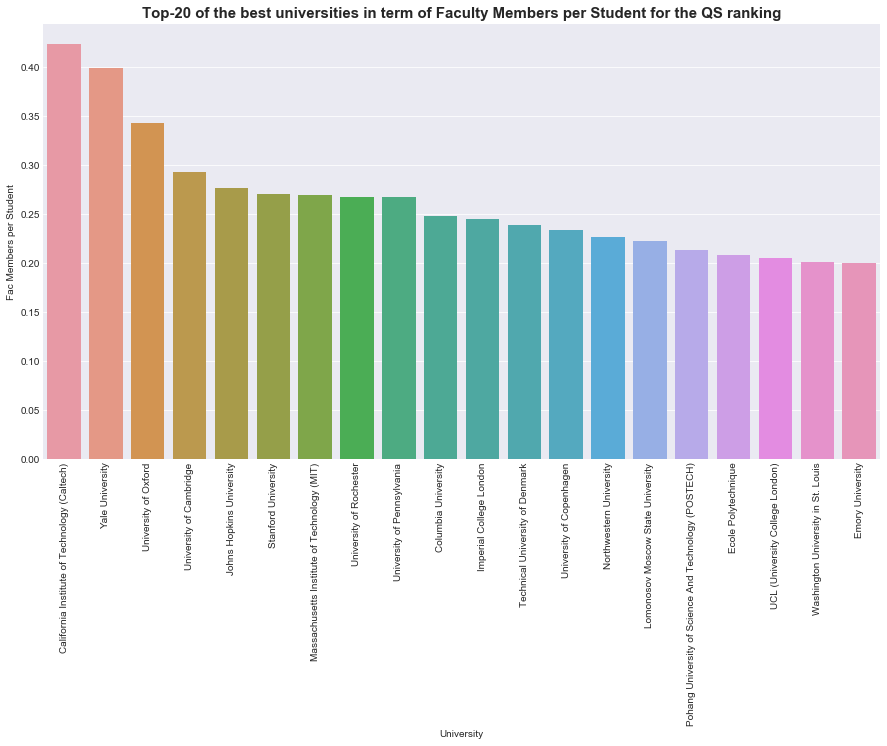

In [15]:
bars("Top-20 of the best universities in term of Faculty Members per Student for the QS ranking", df_ranking_qs.sort_values('Fac Members per Student', ascending=False)[:20], 'University', 'Fac Members per Student')

We observe that this ranking is different from the original ranking, but the 10 first university are almost all in the top 20 of the initial ranking.

#### b) Which are the best universities in term of ratio of international students?

In [16]:
df_ranking_qs['% International Students'] = df_ranking_qs['International Students']/df_ranking_qs['Total Students']*100

In [17]:
df_ranking_qs.sort_values('% International Students', ascending=False)

,Rank,University,Score,Country,Region,Total Faculty Members,International Faculty Members,Total Students,International Students,Fac Members per Student,% International Students
34,35,London School of Economics and Political Scien...,81.8,United Kingdom,Europe,1088.0,687.0,9760.0,6748.0,0.111475,69.139344
11,12,Ecole Polytechnique Fédérale de Lausanne (EPFL),91.2,Switzerland,Europe,1695.0,1300.0,10343.0,5896.0,0.163879,57.004738
7,8,Imperial College London,93.7,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,0.244251,54.356743
198,200,Maastricht University,47.9,Netherlands,Europe,1277.0,502.0,16385.0,8234.0,0.077937,50.253280
47,=47,Carnegie Mellon University,78.6,United States,North America,1342.0,425.0,13356.0,6385.0,0.100479,47.806229
6,7,UCL (University College London),94.6,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0,0.204151,47.792793
91,92,University of St Andrews,65.3,United Kingdom,Europe,1140.0,485.0,8800.0,4030.0,0.129545,45.795455
41,=41,The University of Melbourne,80.4,Australia,Oceania,3311.0,1477.0,42182.0,18030.0,0.078493,42.743350
126,127,Queen Mary University of London,58.3,United Kingdom,Europe,1885.0,801.0,16135.0,6806.0,0.116827,42.181593
25,26,The University of Hong Kong,85.5,Hong Kong,Asia,3012.0,2085.0,20214.0,8230.0,0.149006,40.714356


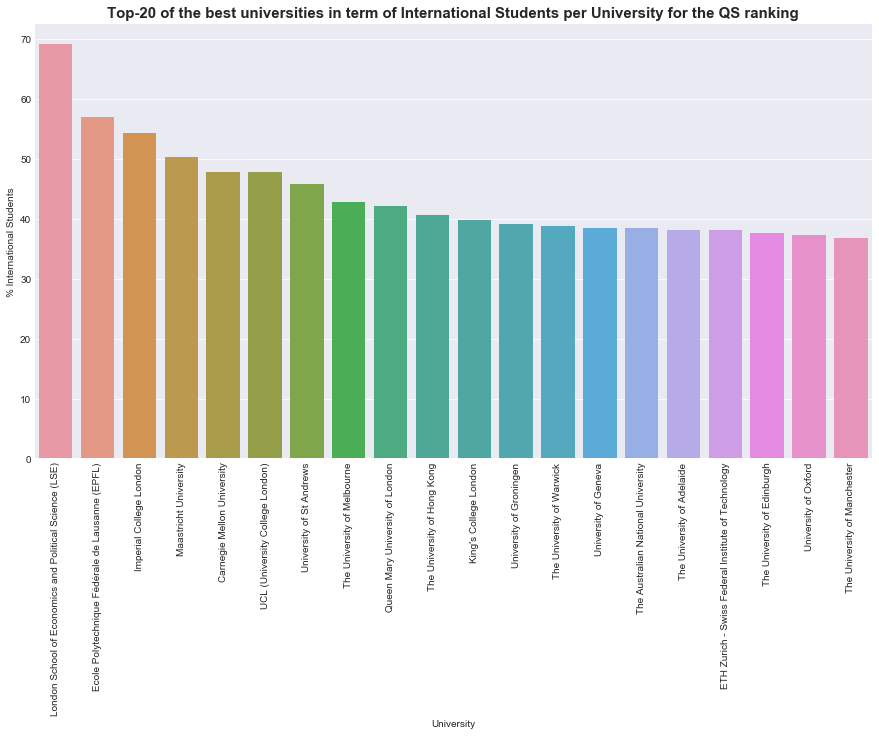

In [18]:
bars("Top-20 of the best universities in term of International Students per University for the QS ranking", df_ranking_qs.sort_values('% International Students', ascending=False)[:20], 'University', '% International Students')

Here, the results are completely different from the original ranking. In the top 20 of the original ranking, 11 universities are from North America. Here, only one american university is in the top 20, and 15 are european universities, which makes sense as it is known that many european students go study in nearby countries in Europe.

#### c) Aggregating the data by country

Concerning the aggregation by country, we choose two types of representation.  
First we found, for each country present in the top-200 of the QS ranking, the best university in terms of *Faculty members per student* and *Percentage of International Students* and we stored the result in a dataframe sorted in a decreasing order according to the studied parameter.   
Secondly, we decided to plot the mean of these two variables for each country present in the top-200 as it seems an interesting way to visualize the results. We should precise that it's the mean of *Faculty members per student* and *Percentage of International Students* for the universities present in the top-200 ranking and not all the universities of the country.

##### - In terms of Ratio between Faculty members and Students

In [19]:
qs_ratioFacStu_country=df_ranking_qs.loc[df_ranking_qs.groupby("Country")["Fac Members per Student"].idxmax()]
qs_ratioFacStu_country[['Country','University','Fac Members per Student']].set_index('Country').sort_values('Fac Members per Student',ascending=False).head()

,University,Fac Members per Student
Country,,
United States,California Institute of Technology (Caltech),0.422616
United Kingdom,University of Oxford,0.342292
Denmark,Technical University of Denmark,0.238455
Russia,Lomonosov Moscow State University,0.221910
South Korea,Pohang University of Science And Technology (P...,0.213025


The best university (QS top-200 ranking) in term of ratio between faculty members and students is the Caltech university in United States where there is one faculty members per a little more than two students.

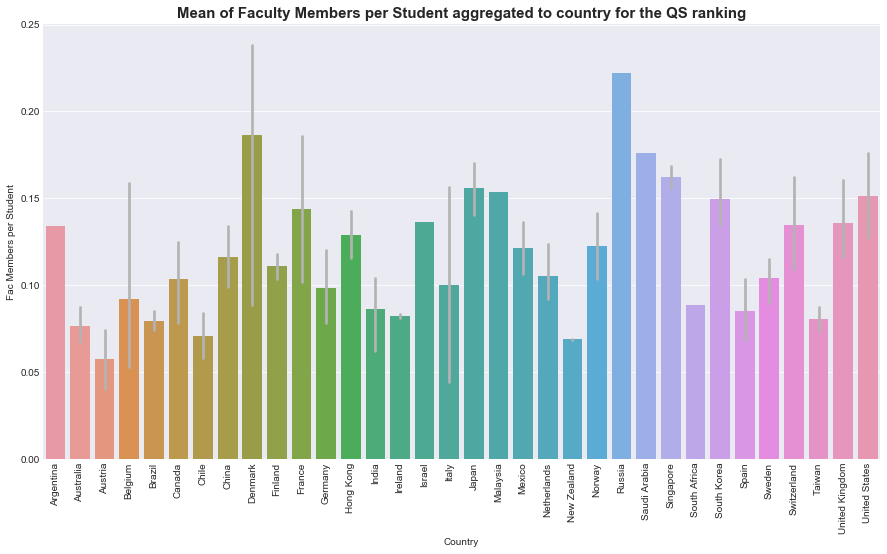

In [20]:
bars("Mean of Faculty Members per Student aggregated to country for the QS ranking", df_ranking_qs.sort_values('Country'), 'Country', 'Fac Members per Student')

We can observe that Russia obtain the best score, but as there is no standard deviation, we guess that there is only one school taken in account, and this result thus is not very relevant (same for Saudi Arabia). On the other hand, we see that Danemark has also a good ratio for faculty members, but its standard deviation is high, which implies that this ratio is very heterogeneous among the universities.

##### - In terms of Percentage of International Students

In [21]:
qs_percInterStu_country=df_ranking_qs.loc[df_ranking_qs.groupby("Country")["% International Students"].idxmax()]
qs_percInterStu_country[['Country','University','% International Students']].set_index('Country').sort_values('% International Students',ascending=False).head()

,University,% International Students
Country,,
United Kingdom,London School of Economics and Political Scien...,69.139344
Switzerland,Ecole Polytechnique Fédérale de Lausanne (EPFL),57.004738
Netherlands,Maastricht University,50.253280
United States,Carnegie Mellon University,47.806229
Australia,The University of Melbourne,42.743350


The United Kingdom has the university with the best ratio of international students, the London School of Economics and Political Science university where 69% of their students are international.

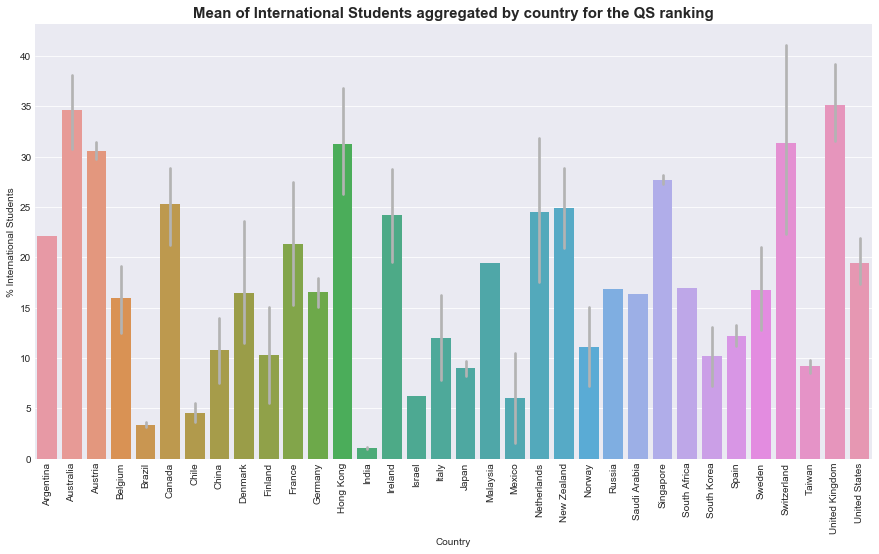

In [22]:
bars("Mean of International Students aggregated by country for the QS ranking", df_ranking_qs.sort_values('Country'), 'Country', '% International Students')

The best countries in term of international students are the United Kingdom, Australia, Hong Kong, Switzerland, and Austria. It is not a surprise that the United Kingdom has the best ratio of international students, as it can attract a lot of european students by its proximity and by the fact that most people speak english.

#### d) Aggregating the data by region

As for the aggregation by country, we first found by region the university with the best results in the Faculty members per Student and Percentage of International Students respectively, and we plot the mean for each region.

##### - In terms of Ratio between Faculty members and Students

In [23]:
qs_ratioFacStu_region=df_ranking_qs.loc[df_ranking_qs.groupby("Region")["Fac Members per Student"].idxmax()]
qs_ratioFacStu_region[['Region','Country','University','Fac Members per Student']].set_index('Region').sort_values('Fac Members per Student',ascending=False)

,Country,University,Fac Members per Student
Region,,,
North America,United States,California Institute of Technology (Caltech),0.422616
Europe,United Kingdom,University of Oxford,0.342292
Asia,South Korea,Pohang University of Science And Technology (P...,0.213025
Latin America,Mexico,Instituto Tecnológico y de Estudios Superiores...,0.136214
Oceania,Australia,The Australian National University,0.110788
Africa,South Africa,University of Cape Town,0.088450


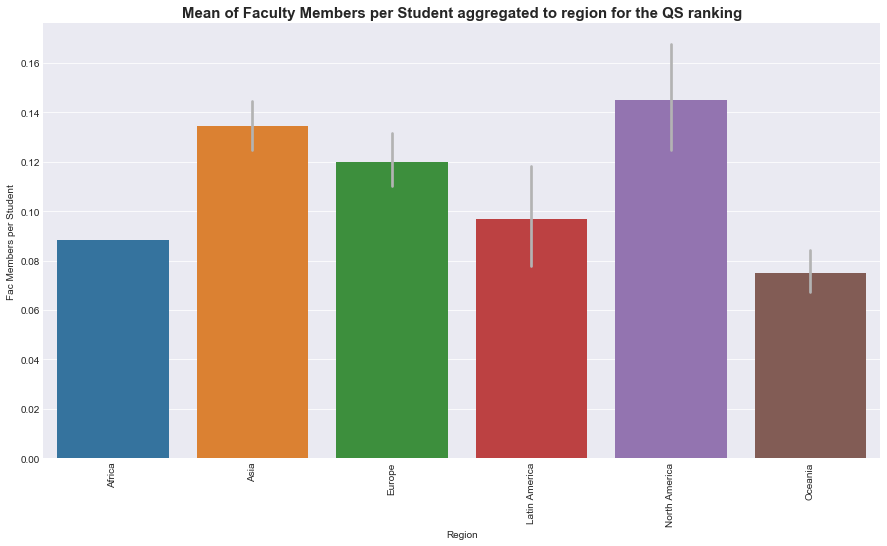

In [24]:
bars("Mean of Faculty Members per Student aggregated to region for the QS ranking", df_ranking_qs.sort_values('Region'), 'Region', 'Fac Members per Student')

##### - In terms of Percentage of International Students

In [25]:
qs_percInterStu_region=df_ranking_qs.loc[df_ranking_qs.groupby("Region")["% International Students"].idxmax()]
qs_percInterStu_region[['Region','Country','University','% International Students']].set_index('Region').sort_values('% International Students',ascending=False)

,Country,University,% International Students
Region,,,
Europe,United Kingdom,London School of Economics and Political Scien...,69.139344
North America,United States,Carnegie Mellon University,47.806229
Oceania,Australia,The University of Melbourne,42.743350
Asia,Hong Kong,The University of Hong Kong,40.714356
Latin America,Argentina,Universidad de Buenos Aires (UBA),22.165804
Africa,South Africa,University of Cape Town,16.970347


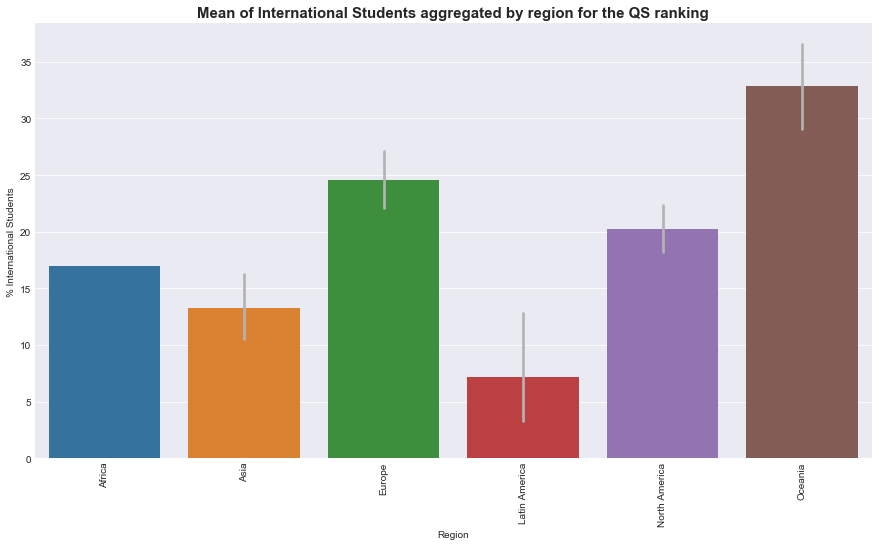

In [26]:
bars("Mean of International Students aggregated by region for the QS ranking", df_ranking_qs.sort_values('Region'), 'Region', '% International Students')

## Question 2

Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

Using Postman, a API request was captured on the ranking, containing a json file with all the data.

In [27]:
times_r=requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
data=times_r.text

We decode the json file by keeping only the first 200 data items (each data item corresponds to an university, sorting according its ranking). Furthemore, we just extract the useful columns (name, location, rank, total number of students, percentage of international students and student/staff ratio). 

As we are asked to sort the universities according their ratio between faculty members and students, we're already converted the student/staff ratio to staff/student ratio.

In [28]:
df_times = pd.DataFrame(json.loads(data)['data'][:200],columns=['name','location','rank','scores_overall','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio'])
df_times['scores_overall'] = df_times['scores_overall'].astype(float)
df_times['stats_pc_intl_students'] = df_times['stats_pc_intl_students'].astype(str).str.replace('%','').astype(int)
df_times['stats_number_students'] = df_times['stats_number_students'].astype(str).str.replace(',','').astype(float)
df_times['stats_student_staff_ratio'] = 1/(df_times['stats_student_staff_ratio'].astype(float))
df_times.columns = ['University','Country','Rank','Score','Total Students','% International Students','Fac Members per Student']
df_times.head()


,University,Country,Rank,Score,Total Students,% International Students,Fac Members per Student
0,University of Oxford,United Kingdom,1,94.3,20409.0,38,0.089286
1,University of Cambridge,United Kingdom,2,93.2,18389.0,35,0.091743
2,California Institute of Technology,United States,=3,93.0,2209.0,27,0.153846
3,Stanford University,United States,=3,93.0,15845.0,22,0.133333
4,Massachusetts Institute of Technology,United States,5,92.5,11177.0,34,0.114943


We don't have the region information in the second website so we decide to use the information present in the first one.  
In order to have a broader panel of Country-Region relation, we extract this time the overall ranking of the QS website but keeping only the Country and Region variables and we keep the unique combinations that we will join on our Times ranking dataframe.

In [29]:
conv_to_cont = pd.DataFrame(data_QS.json()['data'],columns=['country','region']).drop_duplicates()
conv_to_cont.columns=['Country','Region'];
conv_to_cont.head()

,Country,Region
0,United States,North America
4,United Kingdom,Europe
9,Switzerland,Europe
10,Singapore,Asia
19,Australia,Oceania


Then, we merged the two dataframes on the country attribute.

In [30]:
df_ranking_times=pd.merge(df_times, conv_to_cont,how='left',left_on="Country",right_on="Country")


In [31]:
df_ranking_times[df_ranking_times.Region.isnull()]

,University,Country,Rank,Score,Total Students,% International Students,Fac Members per Student,Region
178,University of Luxembourg,Luxembourg,=179,53.8,4969.0,57,0.068493,NaN
193,Lomonosov Moscow State University,Russian Federation,194,52.3,29236.0,22,0.136986,NaN


As we can see above, two universities have no defined Region because the information about these countries was missing in the first ranking. We complete manually the missing information as just two universities are concerned and they won't appear on the barplot when we'll aggregate ranking by region otherwise.

In [32]:
df_ranking_times.at[178,'Region']='Europe'
df_ranking_times.at[193,'Region']='Europe'

Some informations are not explicitely present in our data as the number of international students and the total number of faculty members but we can infer them with the other columns according the following formulas :

Number of international students : *0.01 x Percentage of International Students x Total number of Students*

Total number of faculty members : *Total number of students x Ratio between Faculty members and Students*

Nethertheless, we cannot infer the number of international faculty members but it is not essential for the results.

In [33]:
df_ranking_times['International Students'] = (df_ranking_times["Total Students"] * 0.01 * df_ranking_times["% International Students"]).astype(int)
df_ranking_times['Total Faculty Members'] = (df_ranking_times["Total Students"] * df_ranking_times["Fac Members per Student"]).astype(int)
df_ranking_times.head()

,University,Country,Rank,Score,Total Students,% International Students,Fac Members per Student,Region,International Students,Total Faculty Members
0,University of Oxford,United Kingdom,1,94.3,20409.0,38,0.089286,Europe,7755,1822
1,University of Cambridge,United Kingdom,2,93.2,18389.0,35,0.091743,Europe,6436,1687
2,California Institute of Technology,United States,=3,93.0,2209.0,27,0.153846,North America,596,339
3,Stanford University,United States,=3,93.0,15845.0,22,0.133333,North America,3485,2112
4,Massachusetts Institute of Technology,United States,5,92.5,11177.0,34,0.114943,North America,3800,1284


#### a) Which are the best universities in term of ratio between faculty members and students ?
For the following questions, we choose to present the results the same way as for the QS ranking (see explanations in Qu.1).

In [34]:
df_ranking_times.sort_values('Fac Members per Student', ascending=False)

,University,Country,Rank,Score,Total Students,% International Students,Fac Members per Student,Region,International Students,Total Faculty Members
105,Vanderbilt University,United States,=105,60.0,12011.0,13,0.303030,North America,1561,3639
109,University of Copenhagen,Denmark,=109,59.4,30395.0,14,0.243902,Europe,4255,7413
153,University of Rochester,United States,=153,55.6,9636.0,29,0.232558,North America,2794,2240
11,Yale University,United States,12,87.6,12155.0,21,0.232558,North America,2552,2826
12,Johns Hopkins University,United States,13,86.5,15498.0,24,0.232558,North America,3719,3604
97,Emory University,United States,98,60.7,12649.0,19,0.227273,North America,2403,2874
16,Duke University,United States,17,85.1,15256.0,22,0.222222,North America,3356,3390
114,École Polytechnique,France,115,59.1,2799.0,36,0.196078,Europe,1007,548
183,Scuola Normale Superiore di Pisa,Italy,184,53.4,515.0,7,0.192308,Europe,36,99
101,University of Pittsburgh,United States,=100,60.5,26367.0,10,0.169492,North America,2636,4468


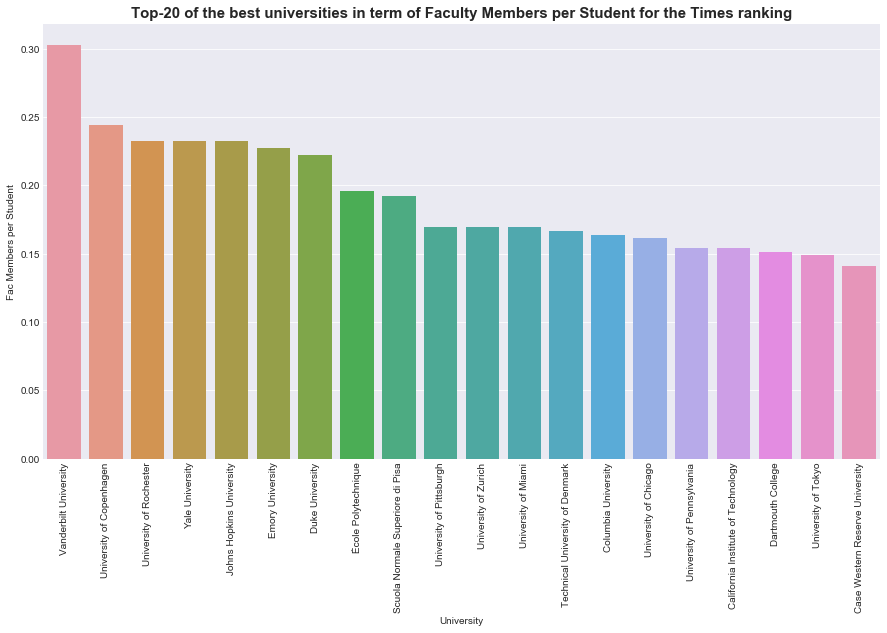

In [35]:
bars("Top-20 of the best universities in term of Faculty Members per Student for the Times ranking", df_ranking_times.sort_values('Fac Members per Student', ascending=False)[:20], 'University', 'Fac Members per Student')


#### b) Which are the best universities in term of ratio of international students?

In [36]:
df_ranking_times.sort_values('% International Students', ascending=False)

,University,Country,Rank,Score,Total Students,% International Students,Fac Members per Student,Region,International Students,Total Faculty Members
24,London School of Economics and Political Science,United Kingdom,=25,79.4,10065.0,71,0.081967,Europe,7146,825
178,University of Luxembourg,Luxembourg,=179,53.8,4969.0,57,0.068493,Europe,2832,340
37,École Polytechnique Fédérale de Lausanne,Switzerland,=38,75.3,9928.0,55,0.089286,Europe,5460,886
7,Imperial College London,United Kingdom,8,89.2,15857.0,55,0.087719,Europe,8721,1390
102,Maastricht University,Netherlands,103,60.4,16727.0,50,0.055556,Europe,8363,929
15,University College London,United Kingdom,16,85.3,30304.0,49,0.095238,Europe,14848,2886
143,University of St Andrews,United Kingdom,=143,56.6,9005.0,48,0.076923,Europe,4322,692
23,Carnegie Mellon University,United States,24,81.9,12676.0,45,0.074074,North America,5704,938
120,Queen Mary University of London,United Kingdom,121,58.5,15405.0,45,0.075188,Europe,6932,1158
39,University of Hong Kong,Hong Kong,40,75.1,18364.0,42,0.055556,Asia,7712,1020


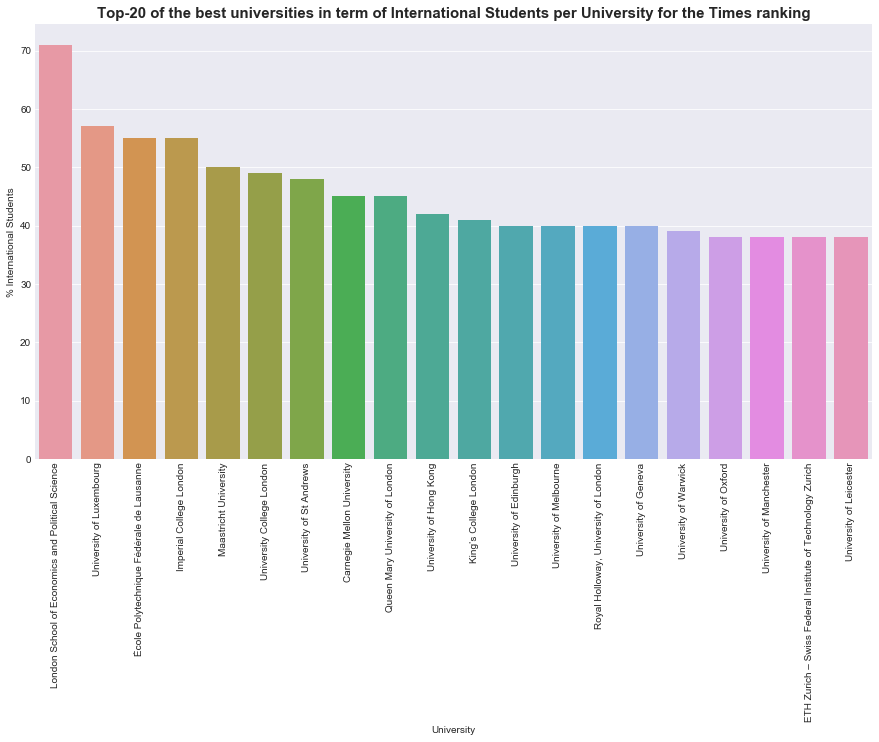

In [37]:
bars("Top-20 of the best universities in term of International Students per University for the Times ranking", df_ranking_times.sort_values('% International Students', ascending=False)[:20], 'University', '% International Students')

#### c) Aggregating the data by country

Again, we use the same representations as for Question 1 to answer to these questions.

##### - In terms of Ratio between Faculty members and Students

In [38]:
times_ratioFacStu_country=df_ranking_times.loc[df_ranking_times.groupby("Country")["Fac Members per Student"].idxmax()]
times_ratioFacStu_country[['Country','University','Fac Members per Student']].set_index('Country').sort_values('Fac Members per Student',ascending=False).head()

,University,Fac Members per Student
Country,,
United States,Vanderbilt University,0.303030
Denmark,University of Copenhagen,0.243902
France,École Polytechnique,0.196078
Italy,Scuola Normale Superiore di Pisa,0.192308
Switzerland,University of Zurich,0.169492


The United Kingdom are no longer in the top-5 of the countries with the best Faculty Members per Student ratio, compared to the QS ranking.

Furthermore, we can see that the maximum ratio is much smaller than the QS ranking, which is strange since it is an official information that should not depend on any ranking.

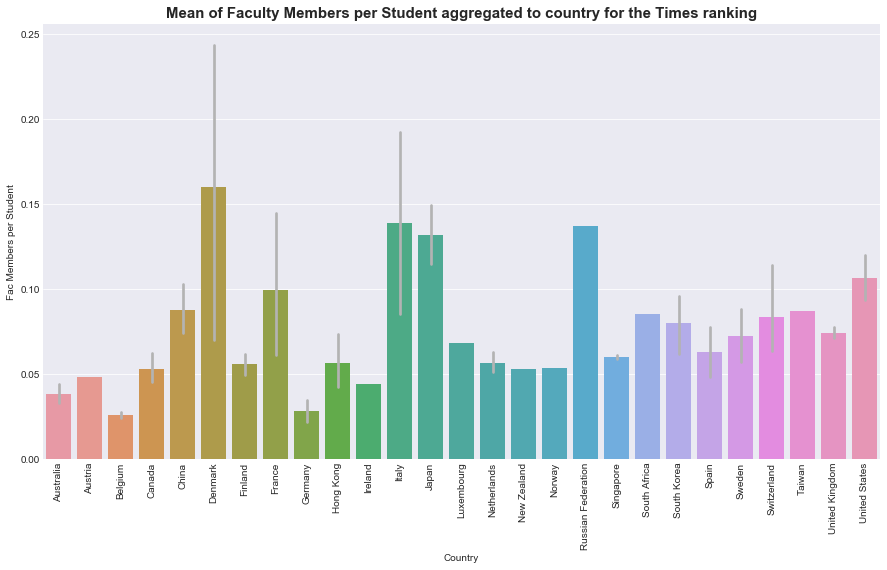

In [39]:
bars("Mean of Faculty Members per Student aggregated to country for the Times ranking", df_ranking_times.sort_values('Country'), 'Country', 'Fac Members per Student')

##### - In terms of Percentage of International Students

In [40]:
times_percInterStu_country=df_ranking_times.loc[df_ranking_times.groupby("Country")["% International Students"].idxmax()]
times_percInterStu_country[['Country','University','% International Students']].set_index('Country').sort_values('% International Students',ascending=False).head()

,University,% International Students
Country,,
United Kingdom,London School of Economics and Political Science,71
Luxembourg,University of Luxembourg,57
Switzerland,École Polytechnique Fédérale de Lausanne,55
Netherlands,Maastricht University,50
United States,Carnegie Mellon University,45


The results are much more similar to the QS rankings compared to the previous parameter. Indeed, the United Kingdom is also the country with the best university in terms of Percentage of International Students. The Luxembourg is the second one but the University of Luxembourg is not present in the top-200 of QS ranking.

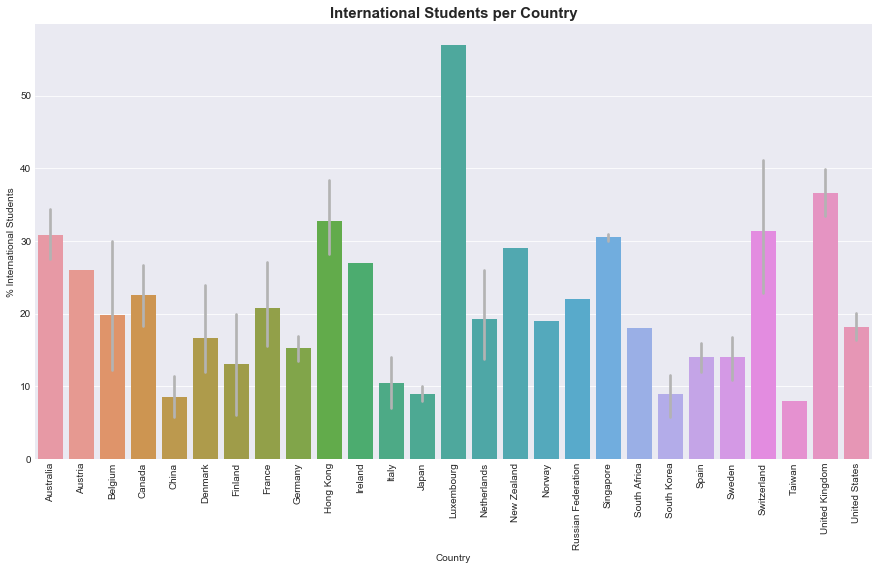

In [41]:
bars("International Students per Country", df_ranking_times.sort_values('Country'), 'Country', '% International Students')

#### d) Aggregating the data by region

##### - In terms of Ratio between Faculty members and Students

In [42]:
times_ratioFacStu_region=df_ranking_times.loc[df_ranking_times.groupby("Region")["Fac Members per Student"].idxmax()]
times_ratioFacStu_region[['Region','Country','University','Fac Members per Student']].set_index('Region').sort_values('Fac Members per Student',ascending=False)

,Country,University,Fac Members per Student
Region,,,
North America,United States,Vanderbilt University,0.303030
Europe,Denmark,University of Copenhagen,0.243902
Asia,Japan,University of Tokyo,0.149254
Africa,South Africa,University of Cape Town,0.085470
Oceania,New Zealand,University of Auckland,0.053191


The ranking of the best Regions in term of the Ration between Faculty members and Students is exactly the same as for the QS rankings, even if the values for this parameter are sensibly differents between the two rankings as we mentionned before.

Indeed, there is a huge gap between the different regions and this explained why there is no change on the top-5.  

It is also interesting to notice that there aren't universities from Latin America countries in the Times ranking.

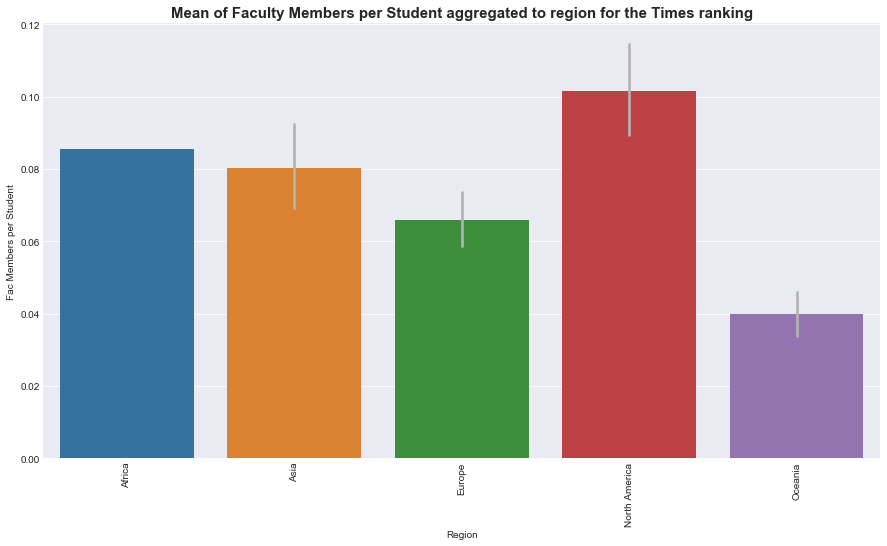

In [43]:
bars("Mean of Faculty Members per Student aggregated to region for the Times ranking", df_ranking_times.sort_values('Region'), 'Region', 'Fac Members per Student')


In [44]:
times_percInterStu_region=df_ranking_times.loc[df_ranking_times.groupby("Region")["% International Students"].idxmax()]
times_percInterStu_region[['Region','Country','University','% International Students']].set_index('Region').sort_values('% International Students',ascending=False)

,Country,University,% International Students
Region,,,
Europe,United Kingdom,London School of Economics and Political Science,71
North America,United States,Carnegie Mellon University,45
Asia,Hong Kong,University of Hong Kong,42
Oceania,Australia,University of Melbourne,40
Africa,South Africa,University of Cape Town,18


Except for the Latin America region which doesn't appears on the dataframe as we said before, the ranking of Region according the best universities in termns of Percentage of International Students is exactly the same between the two rankings (same country, same university and nearly the same percentage)

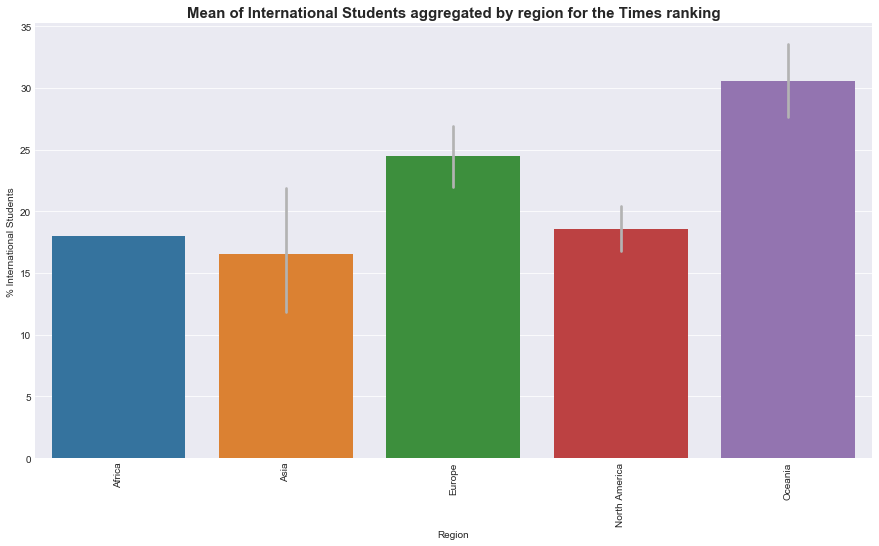

In [45]:
bars("Mean of International Students aggregated by region for the Times ranking", df_ranking_times.sort_values('Region'), 'Region', '% International Students')

We save our current results in a pickle file.

In [46]:
pickle.dump( df_ranking_qs , open( "qs.p", "wb" ) )
pickle.dump( df_ranking_times , open( "times.p", "wb") )

In [47]:
df_ranking_qs = pickle.load(open( "qs.p", "rb" ))
df_ranking_times = pickle.load(open( "times.p", "rb" ))

## Question 3


Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

First, we try a naive inner (by default) merge on the "University" columns and we obtain 105 rows, meaning only about half of the university names matched.

In [48]:
df_ranking_qs.merge(df_ranking_times,on="University")

,Rank_x,University,Score_x,Country_x,Region_x,Total Faculty Members_x,International Faculty Members,Total Students_x,International Students_x,Fac Members per Student_x,% International Students_x,Country_y,Rank_y,Score_y,Total Students_y,% International Students_y,Fac Members per Student_y,Region_y,International Students_y,Total Faculty Members_y
0,2,Stanford University,98.7,United States,North America,4285.0,2042.0,15878.0,3611.0,0.269870,22.742159,United States,=3,93.0,15845.0,22,0.133333,North America,3485,2112
1,3,Harvard University,98.4,United States,North America,4350.0,1311.0,22429.0,5266.0,0.193945,23.478532,United States,6,91.8,20326.0,26,0.112360,North America,5284,2283
2,5,University of Cambridge,95.6,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,0.292488,35.689931,United Kingdom,2,93.2,18389.0,35,0.091743,Europe,6436,1687
3,6,University of Oxford,95.3,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,0.342292,37.287018,United Kingdom,1,94.3,20409.0,38,0.089286,Europe,7755,1822
4,8,Imperial College London,93.7,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,0.244251,54.356743,United Kingdom,8,89.2,15857.0,55,0.087719,Europe,8721,1390
5,9,University of Chicago,93.5,United States,North America,2449.0,635.0,13557.0,3379.0,0.180645,24.924393,United States,9,88.6,13525.0,25,0.161290,North America,3381,2181
6,13,Princeton University,91.0,United States,North America,1007.0,246.0,8069.0,1793.0,0.124799,22.220845,United States,7,91.1,7955.0,24,0.120482,North America,1909,958
7,14,Cornell University,90.7,United States,North America,2718.0,970.0,21904.0,5411.0,0.124087,24.703251,United States,19,84.2,21850.0,24,0.102041,North America,5244,2229
8,16,Yale University,90.4,United States,North America,4940.0,1708.0,12402.0,2469.0,0.398323,19.908079,United States,12,87.6,12155.0,21,0.232558,North America,2552,2826
9,17,Johns Hopkins University,89.8,United States,North America,4462.0,1061.0,16146.0,4105.0,0.276353,25.424254,United States,13,86.5,15498.0,24,0.232558,North America,3719,3604


So we take a closer look at the list of names for each ranking :

In [49]:
pd.DataFrame({"qs":df_ranking_qs["University"],"times":df_ranking_times["University"]})

,qs,times
0,Massachusetts Institute of Technology (MIT),University of Oxford
1,Stanford University,University of Cambridge
2,Harvard University,California Institute of Technology
3,California Institute of Technology (Caltech),Stanford University
4,University of Cambridge,Massachusetts Institute of Technology
5,University of Oxford,Harvard University
6,UCL (University College London),Princeton University
7,Imperial College London,Imperial College London
8,University of Chicago,University of Chicago
9,ETH Zurich - Swiss Federal Institute of Techno...,ETH Zurich – Swiss Federal Institute of Techno...


We notice a lot of universities have their initials in parenthesis after their name in the QS ranking, so we start by removing those parenthesis.

In [50]:
df_ranking_qs["University"] = df_ranking_qs["University"].str.replace(r"\(.*\)","").str.strip()

In [51]:
df_ranking_qs.merge(df_ranking_times,on="University").shape[0]

115

We only obtain a slight improvement of 10 more matches. 
This is definitely not enough and even by further study of the 2 sets of names, there doesn't seem to be any other way to bump this number up.

So we try a new approach : the standard python library *difflib* offers an effective way to measure string similarity with its *SequenceMatcher* class.
We compare the two lists of names two by two, and if the best match is above a certain threshold of similarity, we map the two names together.
The similarity threshold is calibrated after some trials in order to make sure we don't wrongly match too many names (high enough) but still have enough flexibility (low enough) to match all the universities that appear on both rankings.

In [52]:
from difflib import SequenceMatcher

df_ranking_qs = pickle.load(open( "qs.p", "rb" )) #just to reset our previous modification of the names

name_map = {}
threshold = 0.85

for name1 in df_ranking_qs["University"]:
    best_ratio = 0
    match = ""
    for name2 in df_ranking_times["University"]:
        ratio = SequenceMatcher(None,name1,name2).ratio()
        if ratio > best_ratio:       # we find the maximum similarity
            best_ratio = ratio
            match = name2
    if (best_ratio > threshold):     # if it's superior to our threshold we add that couple to the mapping
        name_map[name1] = match

print("Nb of matches :",len(name_map))
name_map

Nb of matches : 149


{'Aalto University': 'Aalto University',
 'Aarhus University': 'Aarhus University',
 'Boston University': 'Boston University',
 'Brown University': 'Brown University',
 'California Institute of Technology (Caltech)': 'California Institute of Technology',
 'Cardiff University': 'Cardiff University',
 'Carnegie Mellon University': 'Carnegie Mellon University',
 'City University of Hong Kong': 'City University of Hong Kong',
 'Columbia University': 'Columbia University',
 'Cornell University': 'Cornell University',
 'Dartmouth College': 'Dartmouth College',
 'Delft University of Technology': 'Delft University of Technology',
 'Duke University': 'Duke University',
 'Durham University': 'Durham University',
 'ETH Zurich - Swiss Federal Institute of Technology': 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'Ecole Polytechnique': 'École Polytechnique',
 'Ecole Polytechnique Fédérale de Lausanne (EPFL)': 'École Polytechnique Fédérale de Lausanne',
 'Eindhoven University of Tec

The result is much more pleasing : we obtain 149 matches. But going through that mapping, we notice some names appear several times on the value side, which means we wrongly mapped some universities. Let's see which ones :

In [53]:
l = list(name_map.values())
duplicates = [x for x in l if l.count(x) > 1]
duplicates

['KTH Royal Institute of Technology',
 'KTH Royal Institute of Technology',
 'Eindhoven University of Technology',
 'University of Oslo',
 'University of Basel',
 'University of Oslo',
 'University of Basel',
 'University of Bern',
 'University of Bern',
 'Eindhoven University of Technology']

Only 5 universities appear twice, which seems reasonable to correct "by hand".

In [54]:
inv_names = {}
for k, v in name_map.items():
    inv_names[v] = inv_names.get(v, [])
    inv_names[v].append(k)

inv_duplicates = {d:inv_names[d] for d in duplicates}
inv_duplicates

{'Eindhoven University of Technology': ['Eindhoven University of Technology',
  'Vienna University of Technology'],
 'KTH Royal Institute of Technology': ['Tokyo Institute of Technology',
  'KTH Royal Institute of Technology'],
 'University of Basel': ['University of Basel', 'University of Bath'],
 'University of Bern': ['University of Bergen', 'University of Bern'],
 'University of Oslo': ['University of Oslo', 'University of Otago']}

With this reversed mapping of names, we can see that, for example 'Eindhoven University of Technology' has been mapped to both 'Eindhoven University of Technology' and 'Vienna University of Technology', but the Vienna University of Technology does not appear in the Times ranking. A quick check shows that it is the same for the 4 other cases, so we simply correct these 5 entries in our mapping by deleting them.

In [55]:
for k,v in inv_duplicates.items():
    for uni in v:
        if uni != k:
            del(name_map[uni])

print("Nb of matches :",len(name_map))
name_map

Nb of matches : 144


{'Aalto University': 'Aalto University',
 'Aarhus University': 'Aarhus University',
 'Boston University': 'Boston University',
 'Brown University': 'Brown University',
 'California Institute of Technology (Caltech)': 'California Institute of Technology',
 'Cardiff University': 'Cardiff University',
 'Carnegie Mellon University': 'Carnegie Mellon University',
 'City University of Hong Kong': 'City University of Hong Kong',
 'Columbia University': 'Columbia University',
 'Cornell University': 'Cornell University',
 'Dartmouth College': 'Dartmouth College',
 'Delft University of Technology': 'Delft University of Technology',
 'Duke University': 'Duke University',
 'Durham University': 'Durham University',
 'ETH Zurich - Swiss Federal Institute of Technology': 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'Ecole Polytechnique': 'École Polytechnique',
 'Ecole Polytechnique Fédérale de Lausanne (EPFL)': 'École Polytechnique Fédérale de Lausanne',
 'Eindhoven University of Tec

Finally we can do an inner merge between the two rankings on the university name column, and we only show here the basic information, mostly respective ranks, for more clarity.

In [56]:
df_ranking_qs["University"] = [name_map[uni] if uni in name_map.keys() else uni for uni in df_ranking_qs["University"]]

df_merged = df_ranking_qs.merge(df_ranking_times.drop(["Country","Region"],axis=1),on="University",suffixes=("_qs","_times"))
df_merged[["University","Rank_qs","Rank_times","Country","Region"]]

,University,Rank_qs,Rank_times,Country,Region
0,Massachusetts Institute of Technology,1,5,United States,North America
1,Stanford University,2,=3,United States,North America
2,Harvard University,3,6,United States,North America
3,California Institute of Technology,4,=3,United States,North America
4,University of Cambridge,5,2,United Kingdom,Europe
5,University of Oxford,6,1,United Kingdom,Europe
6,University College London,7,16,United Kingdom,Europe
7,Imperial College London,8,8,United Kingdom,Europe
8,University of Chicago,9,9,United States,North America
9,ETH Zurich – Swiss Federal Institute of Techno...,10,=10,Switzerland,Europe


## Question 4
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

First of all, we decided to plot the correlation matrix but not for all the columns of the merged dataframe. We kept only the most important attributes which seemed interesting to compare : the overall score, the total number of students, the ratio between the Faculty members and Students and the percentage of international students.

In order to facilitate the interpretation of the resulting correlation matrix, we plot this symmetrical matrix according a color map (red for positive correlation and blue for negative correlation).

In [57]:
corr_matrix=df_merged[['Score_qs','Total Students_qs','Fac Members per Student_qs','% International Students_qs','Score_times','Total Students_times','Fac Members per Student_times','% International Students_times']].corr()

In [63]:
def corr_plot(corr):   
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='RdBu_r', interpolation='none', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr)), corr.columns);
    plt.suptitle('Correlations Heat Map', fontsize=15, fontweight='bold')
    plt.show()

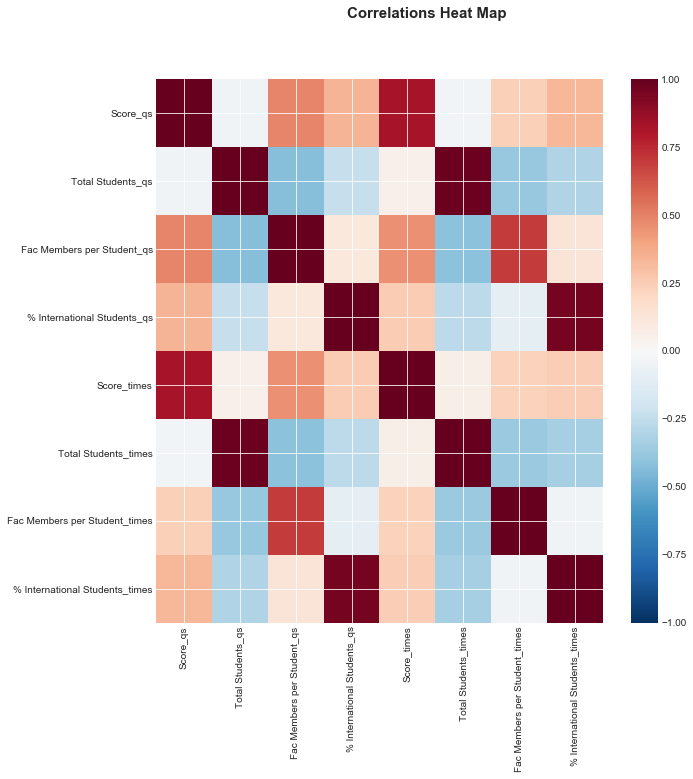

In [64]:
corr_plot(corr_matrix)

As we expected, there is a strong positive correlation between two rankings for the same parameters, as we can see with the upper (or lower because the matrix is symmetrical) red diagonal.

It is also really interesting to see that there is absolutely no correlation between the number of students in the university and its score, for the both rankings.

We also decided to plot the score attributed by the QS ranking versus the score attributed by the Times ranking to see if there was any interesting underlying structure.

In [60]:
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import Set2
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [61]:
source=ColumnDataSource(df_merged)

hover = HoverTool(tooltips=[
    ("University", "@University"),
    ("QS Rank", "@Score_qs"),
    ("Times Rank", "@Score_times"),
    ("Region", "@Region"),
    
])
p = figure(title="HP vs MPG (shaded by CYL)", tools=[hover])
p.circle(x='Score_qs', y='Score_times',source=df_merged,size=12,line_color="white",alpha=0.7, fill_color=factor_cmap('Region', palette=Set2.get(5), factors=df_merged['Region'].unique()))
p.line([49,98], [54,93], alpha=0.6, color='red')
p.xaxis.axis_label = 'Score QS'
p.yaxis.axis_label = 'Score Times'
show(p)

First of all, there is a strong positive correlation between the two rankings which is logical. But we can notice some really interesting observations.

Indeed we can see that the Asian universities have mostly a better score than in the QS ranking than in the Times ranking as well as the Oceanian universities. Furthermore, the European universities are slighty lower than the identity line and the North American universities are slighty upper the identity line. It means that the European universities are generally better rated in the QS ranking and the North American ones better rated in the Times ranking.

## Question 5

Can you find the best university taking in consideration both rankings? Explain your approach.

Considering our data, the best way to combine both rankings seems to be the simplest : averaging the 2 different scores. Before that, we just need to standardize those scores by substracting the mean and dividing by the standard deviation. We then add 5 to get a score out of 10 with 5 being the median, so that all scores are positive and we can compute the average.

In [62]:
std_score_qs = (df_merged['Score_qs'] - df_merged['Score_qs'].mean())/df_merged['Score_qs'].std() + 5
std_score_times = (df_merged['Score_times'] - df_merged['Score_times'].mean())/df_merged['Score_times'].std() + 5

df_merged["Average score"] = (std_score_qs+std_score_times)/2

df_merged.sort_values("Average score",ascending=False)[["University","Average score"]]

,University,Average score
0,Massachusetts Institute of Technology,7.153949
1,Stanford University,7.129706
3,California Institute of Technology,7.094564
2,Harvard University,7.067703
5,University of Oxford,7.065973
4,University of Cambridge,7.029344
7,Imperial College London,6.791040
12,Princeton University,6.777636
8,University of Chicago,6.758282
9,ETH Zurich – Swiss Federal Institute of Techno...,6.712658


Using this score as a ranking, the MIT is the best university.